# [GD16]Labeling_Tool

In [51]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

In [3]:
import glob
import os

home_dir = os.getenv('HOME')+'/lfw'
list_image = sorted(glob.glob(home_dir+'/data/train/input/img/*.png'))
list_label = sorted(glob.glob(home_dir+'/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root = home_dir+'/data/train/input'
label_root = home_dir+'/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23682 23712
Found 23680 images belonging to 1 classes.
Found 23712 images belonging to 1 classes.


In [4]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

In [5]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])


(80, 120, 3) [0.         0.         1.         1.         0.35416666 0.4375    ]
(80, 120, 3) [0.         0.         1.         1.         0.62083334 0.18445946]


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


In [6]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()

(32, 2048)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


In [7]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

In [8]:
def lr_step_decay(epoch):
      init_lr = 0.0005 #self.flag.initial_learning_rate
      lr_decay = 0.5 #self.flag.learning_rate_decay_factor
      epoch_per_decay = 2 #self.flag.epoch_per_decay
      lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
      return lrate

In [15]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 23712 32 741 -> 데이터를 batch_size(32) 의 배수로 맞춰 준비해 주세요. 

assert(image_data.samples % image_data.batch_size == 0)  # 데이터가 32의 배수가 되지 않으면 model.fit()에서 에러가 발생합니다.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=100,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23680 32 740
Epoch 1/100
  6/740 [..............................] - ETA: 18s - loss: 0.0124 - mae: 0.0511

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


740/740 [==============================] - 18s 25ms/step - loss: 0.0134 - mae: 0.0530 0s - loss: 0.0134 - m
Epoch 2/100
740/740 [==============================] - 18s 25ms/step - loss: 0.0130 - mae: 0.0520
Epoch 3/100
740/740 [==============================] - 18s 24ms/step - loss: 0.0129 - mae: 0.0518
Epoch 4/100
740/740 [==============================] - 18s 24ms/step - loss: 0.0127 - mae: 0.0514
Epoch 5/100
740/740 [==============================] - 18s 24ms/step - loss: 0.0127 - mae: 0.0513
Epoch 6/100
740/740 [==============================] - 18s 24ms/step - loss: 0.0126 - mae: 0.0511
Epoch 7/100
740/740 [==============================] - 18s 24ms/step - loss: 0.0125 - mae: 0.0509
Epoch 8/100
740/740 [==============================] - 18s 24ms/step - loss: 0.0125 - mae: 0.0509
Epoch 9/100
740/740 [==============================] - 18s 24ms/step - loss: 0.0125 - mae: 0.0509
Epoch 10/100
740/740 [==============================] - 18s 24ms/step - loss: 0.0124 - mae: 0.0509
Epoch 11/

740/740 [==============================] - 19s 25ms/step - loss: 0.0124 - mae: 0.0508
Epoch 84/100
740/740 [==============================] - 19s 25ms/step - loss: 0.0123 - mae: 0.0507
Epoch 85/100
740/740 [==============================] - 19s 26ms/step - loss: 0.0124 - mae: 0.0507
Epoch 86/100
740/740 [==============================] - 19s 25ms/step - loss: 0.0124 - mae: 0.0507
Epoch 87/100
740/740 [==============================] - 19s 25ms/step - loss: 0.0124 - mae: 0.0508
Epoch 88/100
740/740 [==============================] - 18s 25ms/step - loss: 0.0124 - mae: 0.0508
Epoch 89/100
740/740 [==============================] - 18s 24ms/step - loss: 0.0124 - mae: 0.0508
Epoch 90/100
740/740 [==============================] - 19s 26ms/step - loss: 0.0124 - mae: 0.0508
Epoch 91/100
740/740 [==============================] - 19s 25ms/step - loss: 0.0124 - mae: 0.0507
Epoch 92/100
740/740 [==============================] - 19s 25ms/step - loss: 0.0124 - mae: 0.0508
Epoch 93/100
740/740 [=

In [16]:
IMAGE_SHAPE = (80, 120)

home_dir = os.getenv('HOME')+'/lfw'

val_data_root = home_dir + '/data/val/input'
val_label_root = home_dir + '/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2638 images belonging to 1 classes.
Found 2638 images belonging to 1 classes.


In [17]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


0.01228115800768137 0.050760868936777115


### Epoch 10번

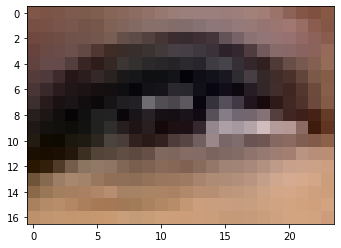

In [12]:
# img test
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(val_data_root+'/img/eye_000010_l.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[1.91395702e-05 3.29171507e-06]
  [1.19999985e+02 7.99999237e+01]
  [4.49719429e+01 2.97716103e+01]]]


[0. 0.]
[120.  80.]
[45. 30.]


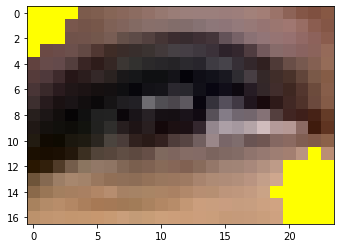

In [14]:
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.5).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

### Epoch 100번

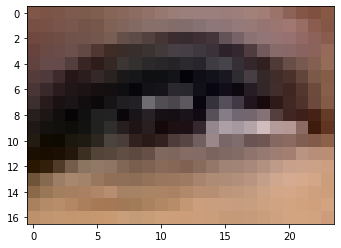

In [18]:
# img test
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(val_data_root+'/img/eye_000010_l.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[3.0912381e-07 3.1093997e-08]
  [1.2000000e+02 8.0000000e+01]
  [4.6561630e+01 2.7211649e+01]]]


[0. 0.]
[120.  80.]
[47. 27.]


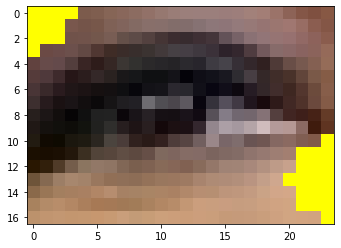

In [20]:
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.5).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

### 당황한 눈

In [52]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [53]:
import os
my_image_path = os.getenv('HOME')+'./aiffel/emoji.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (240, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()


error: OpenCV(4.5.1) /tmp/pip-req-build-hj027r8z/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [39]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

error: OpenCV(4.5.1) /tmp/pip-req-build-hj027r8z/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# 루브릭

1. mean-shift를 활용하여 눈동자 검출 라벨링 추가작업을 원활히 진행하였다.
 - 눈이미지-라벨이미지 쌍의 추가데이터셋을 10000건 이상 충분히 확보하였다.
2. 눈동자 키포인트 검출 딥러닝 모델이 구현되어 안정적으로 학습이 진행되었다.
 - pretrained model 기반의 딥러닝 모델의 트레이닝 loss가 안정적으로 감소함을 확인하였다.
3. 모델이 검출한 눈 위치에 당황한 표정효과 눈 이미지를 합성한 이미지를 생성하였다.
 - 사람 얼굴 이미지에서 딥러닝 모델로 눈동자 키포인트를 검출하여 눈 이미지를 자연스럽게 합성한 결과이미지를 생성하였다.